In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from matplotlib import colors

In [12]:
# ---------------- config ----------------
YEARS = [2020, 2021, 2022, 2023, 2024]
BASE = "xxx"
IN_TEMPLATE = "negH_stats_{year}.nc"

dir_savefig = "xxx"
OUT_PNG = os.path.join(dir_savefig, "global_negH_2020_2024.png")

In [13]:
# ----------------- helpers -----------------
def load_year(path: str) -> xr.Dataset:
    if not os.path.exists(path) or os.path.getsize(path) == 0:
        raise FileNotFoundError(f"Missing or empty file: {path}")
    ds = xr.open_dataset(path, decode_times=False)
    need = [v for v in ["valid_hours", "negH_hours", "sum_negH_Wm2h", "latitude", "longitude"] if v in ds]
    return ds[need]
    

In [14]:
# Load all years into a list
ds_list = [load_year(os.path.join(BASE, IN_TEMPLATE.format(year=y))) for y in YEARS]

# Stack into one Dataset with a 'year' dimension
stacked = xr.concat(
    [d[["valid_hours", "negH_hours", "sum_negH_Wm2h"]] for d in ds_list],
    dim=xr.DataArray(YEARS, dims="year", name="year")
)

# Sum across years
sum_valid   = stacked["valid_hours"].fillna(0).sum("year")
sum_negHh   = stacked["negH_hours"].fillna(0).sum("year")
sum_sumNegH = stacked["sum_negH_Wm2h"].fillna(0.0).sum("year")

# Compute ratios safely
with np.errstate(divide="ignore", invalid="ignore"):
    frac_negH = (sum_negHh / sum_valid).where(sum_valid > 0)     # unitless (0..1)
    mean_negH = (sum_sumNegH / sum_negHh).where(sum_negHh > 0)   # W m^-2


Saved png: fig_2_ERA5_negH.png


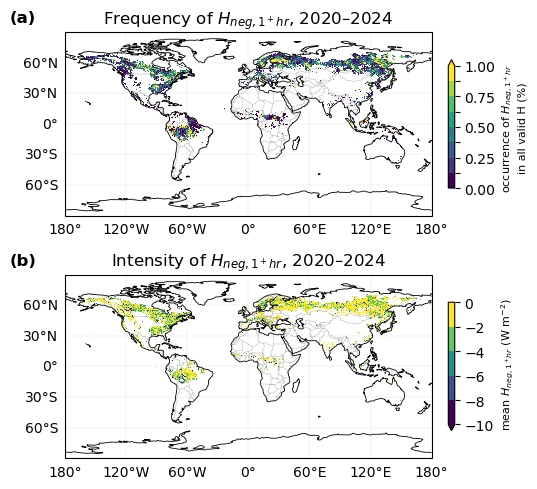

In [25]:
# Sort latitude ascending for plotting
frac_plot = frac_negH.sortby("latitude")
mean_plot = mean_negH.sortby("latitude")

lat = frac_plot["latitude"].values
lon = frac_plot["longitude"].values

# Convert longitudes 0..360 to -180..180, then sort
lon180 = ((lon + 180) % 360) - 180
sort_idx = np.argsort(lon180)
lon180 = lon180[sort_idx]

frac_vals = frac_plot.transpose("latitude", "longitude").values[:, sort_idx]
mean_vals = mean_plot.transpose("latitude", "longitude").values[:, sort_idx]

# Add a cyclic column to avoid seam at the dateline
frac_cyc, lon_cyc = add_cyclic_point(frac_vals, coord=lon180, axis=-1)
mean_cyc, _       = add_cyclic_point(mean_vals, coord=lon180, axis=-1)

# Build 2D lon/lat grids (for pcolormesh)
Lon2D, Lat2D = np.meshgrid(lon_cyc, lat)

# Figure with two GeoAxes
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(9, 5))
ax1 = plt.subplot(2, 1, 1, projection=proj)
ax2 = plt.subplot(2, 1, 2, projection=proj)

# Common map features
for ax in (ax1, ax2):
    ax.set_global()
    ax.coastlines(linewidth=0.6)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3, edgecolor="gray", alpha=0.7)
    gl = ax.gridlines(draw_labels=True, linewidth=0.2, color="gray", alpha=0.5, linestyle="--")
    gl.top_labels = False
    gl.right_labels = False

# ---- Upper: fraction of negative-H hours (discrete viridis, [0, 5%) ----
# Convert to percent and clip to [0, 5)
frac_pct = np.clip(frac_cyc * 100.0, 0.0, 4.999)

# Define discrete bins: 0,1,2,3,4,5 (%); last edge is exclusive due to clipping
bounds = np.arange(0, 1.125, 0.125, dtype=float)  # [0,1,2,3,4,5]
n_bins = len(bounds) - 1
cmap_disc = plt.get_cmap("viridis", n_bins)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=cmap_disc.N, clip=True)

im1 = ax1.pcolormesh(
    Lon2D, Lat2D, frac_pct,
    transform=ccrs.PlateCarree(),
    cmap=cmap_disc,
    norm=norm,
    shading="auto"
)
tick_locs = bounds
tick_labels = [f"{b:.2f}" for b in bounds] 
# Show every 2 ticks only (0.0%, 1.0%, 2.0%)
for i in range(len(tick_labels)):
    if i % 2 != 0:  # blank odd ticks
        tick_labels[i] = ""
cb1 = fig.colorbar(
    im1, ax=ax1, orientation="vertical", shrink=0.7, pad=0.02, fraction=0.06, 
    extend='max', ticks=tick_locs, boundaries=bounds, spacing="proportional"
)
cb1.set_ticklabels(tick_labels)
cb1.set_label("occurrence of $H_{neg,1^+hr}$ \nin all valid H (%)", fontsize=8)
ax1.set_title("Frequency of $H_{neg,1^+hr}$, 2020–2024")
ax1.text(-0.15, 1.12, "(a)", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top", ha="left")

# ---- Lower: mean negative H (W m^-2) during negative hours ----
bounds2 = [-10, -8, -6, -4, -2, 0]
cmap_disc2 = plt.get_cmap("viridis", len(bounds2) - 1)
norm2 = colors.BoundaryNorm(boundaries=bounds2, ncolors=cmap_disc2.N, clip=True)

im2 = ax2.pcolormesh(
    Lon2D, Lat2D, mean_cyc,
    transform=ccrs.PlateCarree(),
    cmap=cmap_disc2,
    norm=norm2,
    shading="auto"
)
cb2 = fig.colorbar(
    im2, ax=ax2, orientation="vertical", shrink=0.7, pad=0.02, fraction=0.06,
    extend='min', ticks=bounds2, boundaries=bounds2, spacing="proportional"
)
cb2.set_label("mean $H_{neg,1^+hr}$ (W m$^{-2}$)", fontsize=8)
ax2.set_title("Intensity of $H_{neg,1^+hr}$, 2020–2024")
ax2.text(-0.15, 1.12, "(b)", transform=ax2.transAxes, fontsize=12, fontweight="bold", va="top", ha="left")

plt.tight_layout()
# save figure
os.makedirs(dir_savefig, exist_ok=True)
filename = "fig_2_ERA5_negH.png"
fig.savefig(os.path.join(dir_savefig, filename), dpi=400, bbox_inches='tight')
print(f"Saved png: {filename}")

plt.show()


In [16]:
### stats
# --- Threshold in fraction units (not %) ---
threshold = 0.0015  # 0.15%

lat = frac_plot["latitude"].values
lon = frac_plot["longitude"].values

# cos(lat) area weighting (normalize later)
weights = np.cos(np.deg2rad(lat))
weights2D = np.repeat(weights[:, None], lon.size, axis=1)

# mask nan
mask = ~np.isnan(frac_plot.values)

# eligible area weights
area_weights = weights2D * mask

# global totals
total_area = np.nansum(area_weights)

# --- Condition: frac_negH > threshold ---
cond = (frac_plot.values > threshold)

# tropical mask
tropics = (lat[:, None] >= -23.5) & (lat[:, None] <= 23.5)

# mid/high mask
mid_high = (np.abs(lat[:, None]) >= 30.0)

# compute area fractions
def area_fraction(region_mask, cond, area_weights):
    area_region = np.nansum(area_weights * region_mask)
    area_exceed = np.nansum(area_weights * region_mask * cond)
    return (area_exceed / area_region) * 100.0 if area_region > 0 else np.nan

tropics_pct = area_fraction(tropics, cond, area_weights)
midhigh_pct = area_fraction(mid_high, cond, area_weights)

print(f"Tropics (-23.5 to 23.5): {tropics_pct:.2f}% of area exceeds 0.15% negH fraction")
print(f"Mid/high lats (30–90): {midhigh_pct:.2f}% of area exceeds 0.15% negH fraction")


Tropics (-23.5 to 23.5): 48.17% of area exceeds 0.15% negH fraction
Mid/high lats (30–90): 74.58% of area exceeds 0.15% negH fraction


In [17]:
# ---------- Global mean negative H (area-weighted grid mean) ----------
# lat and lon arrays
lat = mean_plot["latitude"].values
lon = mean_plot["longitude"].values

# area weights (cos(lat)), expanded to 2D
weights = np.cos(np.deg2rad(lat))
weights2D = np.repeat(weights[:, None], lon.size, axis=1)

# mask nan values
mask = ~np.isnan(mean_plot.values)
area_weights = weights2D * mask

# weighted mean
weighted_mean_negH = np.nansum(mean_plot.values * area_weights) / np.nansum(area_weights)

print(f"Global area-weighted mean negative H: {weighted_mean_negH:.2f} W m^-2")

# ---------- Global mean fraction (area-weighted grid mean) ----------
mask_frac = ~np.isnan(frac_plot.values)
area_weights_frac = weights2D * mask_frac

weighted_mean_frac = np.nansum(frac_plot.values * area_weights_frac) / np.nansum(area_weights_frac)
print(f"Global area-weighted mean fraction of negative H hours: {weighted_mean_frac*100:.3f}%")


Global area-weighted mean negative H: -2.32 W m^-2
Global area-weighted mean fraction of negative H hours: 0.441%
